In [1]:
import numpy as np
import pandas as pd
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
import tensorflow_hub as hub
import tensorflow_text
import tldextract  
import warnings
warnings.filterwarnings('ignore')

from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve, roc_auc_score,f1_score,precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from imblearn.over_sampling import SMOTE,ADASYN
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import re

from collections import Counter
import nltk 
import spacy
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from wordcloud import WordCloud, ImageColorGenerator,STOPWORDS
import gensim
from gensim.parsing.preprocessing import STOPWORDS as gensim_stopwords
import copy
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,LancasterStemmer
from pprint import pprint


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, Dropout, Activation,Embedding,Flatten,LSTM,Bidirectional,GlobalMaxPooling1D
from tensorflow.keras.layers import Reshape,Conv1D, MaxPooling1D, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from keras.backend import clear_session


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings('ignore')

2022-06-21 01:51:21.296269: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-21 01:51:21.304006: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-06-21 01:51:21.304024: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading 

#### Loading the ISOT Full Dataset  -- After combined fake and real news  in the previous notebook   "ISOT_ML_Classifiers_TfiDF_Tokeniser"

In [2]:
isot_full_df = pd.read_csv("Updated//ISOT_Combined_FullData.csv")

##### Consolidating Stopwords list

In [3]:
#loading the english language small model of spacy
import spacy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words

In [4]:
gensim_stopwords_list=list(gensim_stopwords) # gensim
nltk_stopwords_list=stopwords.words('english') # nltk
spacy_stopwords=list(sw_spacy) # spacy
wordcloud_stopwords_list=list(STOPWORDS)

In [5]:
total_stop_words_list= set(gensim_stopwords_list + nltk_stopwords_list + spacy_stopwords + wordcloud_stopwords_list)

#### Helper Function to preprocess the text  with all the operations as mentioned above

In [6]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag,wordnet.NOUN)

porter = PorterStemmer()
lancaster=LancasterStemmer()
lemmatizer = WordNetLemmatizer()

In [7]:
def clean_format(text):
    # Remove HTML tags
    bsoup = BeautifulSoup(text, "html.parser")
    clean_text = bsoup.get_text()
    
    
    # Remove any URL
    url = re.compile(r'https?://\S+|www\.\S+')
    url.sub(r'', clean_text)
    
    # Remove any numbers
    clean_text=re.sub(r'\d+','',clean_text)
    
    # Remove all kinds of date formats
    clean_text=re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', clean_text)
    clean_text=re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', clean_text)
    clean_text=re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', clean_text)
    
    
    # Removal of punctuation and lower case conversion
    clean_text = re.sub('\[[^]]*\]', ' ', clean_text)
    clean_text = re.sub('[^a-zA-Z]',' ',clean_text)  # replaces non-alphabets with spaces
    clean_text = clean_text.lower()
    
    # Removal of 2 consecutive double space
    clean_text=re.sub(r' {2,}',' ',clean_text)
    
    clean_text = clean_text.split()
    
    textclean=[]
    clean_text = [textclean.append(word) for word in clean_text if word not in total_stop_words_list and len(word) > 2]
    clean_text = ' '.join(textclean)
    
#     # Lemmatization
    clean_text = clean_text.split()
    lemmatizer = WordNetLemmatizer()
    newcleantext= [lemmatizer.lemmatize(w) for w in clean_text]
    newcleantext = ' '.join(newcleantext)
    
    return newcleantext

In [8]:
isot_full_df = isot_full_df.drop(columns = ['title','text', 'subject','date','title_length','body_length','date'])

In [9]:
isot_full_df=isot_full_df.reset_index(drop=True)

In [10]:
isot_full_df.head(2)

,class,fulltext
0,0,Macron vows Caribbean rebuild as anger rises against European powers French President Emmanuel Macron vowed to quickly rebuild the islands of the French Caribbean during a visit on Tuesday meant t...
1,0,"Cruz, Rubio say Iran prisoner swap a 'dangerous precedent' Republican presidential candidates Ted Cruz and Marco Rubio praised Iran’s release of five detained Americans on Sunday, but sharply crit..."


In [11]:
isot_full_df['cleantext']=isot_full_df['fulltext'].apply(clean_format)

In [12]:
isot_full_df['cleantext'].head(1)

0    macron vow caribbean rebuild anger rise european power french president emmanuel macron vowed quickly rebuild island french caribbean visit tuesday meant dispel anger government response hurricane...
Name: cleantext, dtype: object

In [13]:
isot_full_df.head(2)

,class,fulltext,cleantext
0,0,Macron vows Caribbean rebuild as anger rises against European powers French President Emmanuel Macron vowed to quickly rebuild the islands of the French Caribbean during a visit on Tuesday meant t...,macron vow caribbean rebuild anger rise european power french president emmanuel macron vowed quickly rebuild island french caribbean visit tuesday meant dispel anger government response hurricane...
1,0,"Cruz, Rubio say Iran prisoner swap a 'dangerous precedent' Republican presidential candidates Ted Cruz and Marco Rubio praised Iran’s release of five detained Americans on Sunday, but sharply crit...",cruz rubio iran prisoner swap dangerous precedent republican presidential candidate ted cruz marco rubio praised iran release detained american sunday sharply criticized deal white house win freed...


In [14]:
df = isot_full_df[isot_full_df['cleantext'].notna()]

In [15]:
## Shuffling the rows
df = df.sample(frac=1).reset_index(drop=True)

In [16]:
X=df['cleantext'].apply(str)
y=df['class']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=0)

In [18]:
#num_words: the maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept.
tokenizer = Tokenizer(num_words=1000,lower= 1, oov_token="<OOV>")

In [19]:
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [57]:
vocab_size=len(tokenizer.word_index) + 1  #10000
embedding_dim=300
maxi=2000
EPOCHS = 2

### Using TFIDF Tokenisation mode

In [23]:
X_train_tokens = tokenizer.texts_to_matrix(X_train, mode='tfidf')
X_test_tokens = tokenizer.texts_to_matrix(X_test, mode='tfidf')

In [58]:
X_train_pad=pad_sequences(X_train_tokens,maxlen=maxi,padding='post')
X_test_pad=pad_sequences(X_test_tokens,maxlen=maxi,padding='post')

In [59]:
#print(type(X_train_tokens))
max(map(len, X_train_pad))

2000

In [60]:
len(tokenizer.word_index)+1

93531

In [27]:
import matplotlib.pyplot as plt


def plot_loss_and_acc(history):
    train_loss = history.history["loss"]
    train_acc = history.history["accuracy"]
    val_loss = history.history["val_loss"]
    val_acc = history.history["val_accuracy"]

    fig = plt.figure(figsize=(12,5))

    ax = fig.add_subplot(121)
    ax.plot(range(len(train_loss)), train_loss, label="Train Loss");
    ax.plot(range(len(val_loss)), val_loss, label="Validation Loss");
    plt.xlabel("Epochs"); plt.ylabel("Loss");
    plt.title("Train Loss vs Validation Loss");
    plt.legend(loc="best");

    ax = fig.add_subplot(122)
    ax.plot(range(len(train_acc)), train_acc, label="Train Accuracy");
    ax.plot(range(len(val_acc)), val_acc, label="Validation Accuracy");
    plt.xlabel("Epochs"); plt.ylabel("Accuracy");
    plt.title("Train Accuracy vs Validation Accuracy");
    plt.legend(loc="best");

## Using 1D CNN

In [48]:
# Model Checkpoint and EarlyStopping
filepath = "Updated//modelISOT_CNN.h5" # Location to get the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list = [checkpoint,es]

In [52]:
warnings.filterwarnings('ignore')
model=Sequential()
model.add(Embedding(vocab_size,embedding_dim,input_length=maxi))
model.add(Conv1D(filters=128, kernel_size=3, padding='valid', activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 300)         28059300  
                                                                 
 conv1d (Conv1D)             (None, 1998, 128)         115328    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 999, 128)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 127872)            0         
                                                                 
 dense (Dense)               (None, 128)               16367744  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                        

In [53]:
clear_session()

In [54]:
warnings.filterwarnings('ignore')
history=model.fit(X_train_pad, y_train, epochs=2, batch_size=64,validation_data=(X_test_pad,y_test), callbacks=callbacks_list)

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
479/479 [==============================] - ETA: 0s - loss: 0.1496 - accuracy: 0.9446WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2bafcfd712f0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and

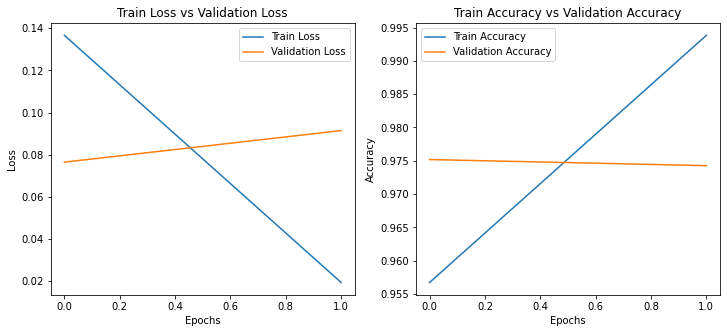

In [50]:
plot_loss_and_acc(history)

### Using LSTM

In [28]:
# Model Checkpoint and EarlyStopping
filepath_lstm = "Updated//modelISOT_LSTM_TFIDF.h5" # Location to get the model
checkpoint_lstm = ModelCheckpoint(filepath_lstm, monitor='loss', verbose=1, save_best_only=True, mode='min')
es_lstm = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list_lstm = [checkpoint_lstm,es_lstm]

In [43]:
# X_train_pad=pad_sequences(X_train_tokens,maxlen=2000,padding='post')
# X_test_pad=pad_sequences(X_test_tokens,maxlen=2000,padding='post')

In [44]:
lstm_model = Sequential(name = 'lstm_nn_model')
lstm_model.add(layer = Embedding(input_dim = vocab_size, output_dim = 300, input_length=2000,trainable=True))

lstm_model.add(LSTM(128,return_sequences=True,dropout=0.2)) # loss stucks at about 
lstm_model.add(GlobalMaxPooling1D())
lstm_model.add(Dense(64,activation='relu'))
lstm_model.add(Dense(1,activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
lstm_model.summary()

Model: "lstm_nn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 300)         28059300  
                                                                 
 lstm (LSTM)                 (None, 2000, 128)         219648    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 28,287,269
Trainable params: 28,287,269
Non-trainable params: 0
_________________________________________

In [45]:
clear_session()

In [47]:
warnings.filterwarnings('ignore')
history_lstm=lstm_model.fit(X_train_pad, y_train, epochs=3, batch_size=128,validation_data=(X_test_pad,y_test), callbacks=callbacks_list_lstm)

Epoch 1/2
 17/240 [=>............................] - ETA: 17:32 - loss: 0.4125 - accuracy: 0.8235

KeyboardInterrupt: 

In [ ]:
plot_loss_and_acc(history_lstm)

### Using BILSTM

In [69]:
# Model Checkpoint and EarlyStopping
filepath_bilstm = "Updated//modelISOT_BiLSTM_TFIDF.h5" # Location to get the model
checkpoint_bilstm = ModelCheckpoint(filepath_bilstm, monitor='loss', verbose=1, save_best_only=True, mode='min')
es_bilstm = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list_bilstm = [checkpoint_bilstm,es_bilstm]

In [70]:
bilstm_model = Sequential(name = 'bilstm_nn_model')
bilstm_model.add(layer = Embedding(input_dim = vocab_size, output_dim = 300, input_length=2000,trainable=True))

bilstm_model.add(Bidirectional(LSTM(128,return_sequences=True,dropout=0.2))) # loss stucks at about 
bilstm_model.add(GlobalMaxPooling1D())
bilstm_model.add(Dense(64,activation='relu'))
bilstm_model.add(Dense(1,activation='sigmoid'))
bilstm_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
bilstm_model.summary()

Model: "bilstm_nn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 300)         28059300  
                                                                 
 bidirectional (Bidirectiona  (None, 2000, 256)        439296    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 28,515,109
Trainable params: 28,515,1

In [71]:
clear_session()

In [72]:
warnings.filterwarnings('ignore')
history_bilstm=bilstm_model.fit(X_train_pad, y_train, epochs=3, batch_size=128,validation_data=(X_test_pad,y_test), callbacks=callbacks_list_bilstm)

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
240/240 [==============================] - ETA: 0s - loss: 0.5841 - accuracy: 0.6868WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2bafcfd71840> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and

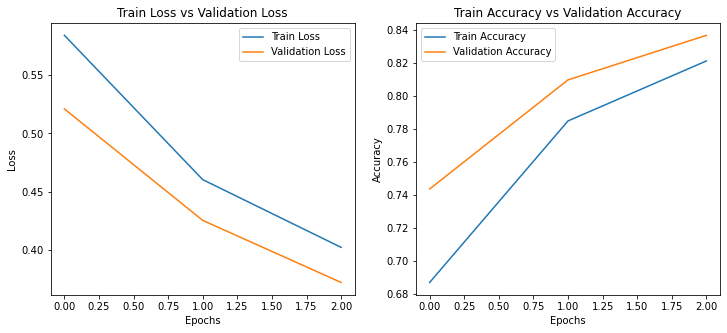

In [73]:
plot_loss_and_acc(history_bilstm)